<a href="https://colab.research.google.com/github/toruuno/DNN_d1d2/blob/master/2_6_simple_convolution_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## Googleドライブのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/lesson_2')
sys.path.append('/content/drive/My Drive/common')
sys.path.append('/content/drive/My Drive')

# simple convolution network

## image to column

In [ ]:
import pickle
import numpy as np
from collections import OrderedDict
from common import layers
from common import optimizer
from data.mnist import load_mnist
import matplotlib.pyplot as plt

# 画像データを２次元配列に変換
'''
input_data: 入力値
filter_h: フィルターの高さ
filter_w: フィルターの横幅
stride: ストライド
pad: パディング
'''
def im2col(input_data, filter_h, filter_w, stride=1, pad=0, test1=False, test2=False):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    if test1==False: col = col.transpose(0, 4, 5, 1, 2, 3) # (N, C, filter_h, filter_w, out_h, out_w) -> (N, filter_w, out_h, out_w, C, filter_h)    
    
    if test2==False: col = col.reshape(N * out_h * out_w, -1)
    return col

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [try] im2colの処理を確認しよう
・関数内でtransposeの処理をしている行をコメントアウトして下のコードを実行してみよう<br>
・input_dataの各次元のサイズやフィルターサイズ・ストライド・パディングを変えてみよう

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# im2colの処理確認
input_data = np.random.rand(2, 1, 4, 4)*100//1 # number, channel, height, widthを表す
filter_h = 3
filter_w = 3
stride = 1
pad = 0

#testがFalseでデフォルトの動き
#testがTrueでtransposeをOffした動き

print('\n\ntransposeをOFF')
print('========== input_data ===========\n', input_data)
print('==============================')
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad, test1=True, test2=False)
print('============= col ==============\n', col)
print('==============================')

print('\n\ntransposeをON')
print('========== input_data ===========\n', input_data)
print('==============================')
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad, test1=False, test2=False)
print('============= col ==============\n', col)
print('==============================')


print("\n\n\nnp.transpose()は配列の軸入れ替えを行う関数")
print("試しにinput_dataにて2次元目と3次元目をひっくり返してみる(input_data.transpose(0,1,3,2))")
print("要素２つが転置行列に変換された")
t_indat = input_data.transpose(0,1,3,2)

print('========== transposed input_data ===========\n', t_indat)
print('==============================')

print("さらにinput_data.transpose(0,3,1,2))だと以下")
t_indat = input_data.transpose(0,3,1,2)
print('========== transposed input_data ===========\n', t_indat)
print('==============================')

print("さらにinput_data.transpose(3,2,1,0))だと以下")
t_indat = input_data.transpose(3,2,1,0)
print('========== transposed input_data ===========\n', t_indat)
print('==============================')

print("ここまでやると直感的には理解できないけど何等か軸の入れ替えされているくらいは理解")



transposeをOFF
========== input_data ===========
 [[[[62. 14. 28. 44.]
   [22. 68.  6. 68.]
   [27. 64. 59. 60.]
   [44. 78. 60. 20.]]]


 [[[79. 38.  8. 14.]
   [ 9.  5. 43. 52.]
   [34. 64.  8. 70.]
   [49. 68. 60. 54.]]]]
============= col ==============
 [[62. 14. 22. 68. 14. 28. 68.  6. 28.]
 [44.  6. 68. 22. 68. 27. 64. 68.  6.]
 [64. 59.  6. 68. 59. 60. 27. 64. 44.]
 [78. 64. 59. 78. 60. 59. 60. 60. 20.]
 [79. 38.  9.  5. 38.  8.  5. 43.  8.]
 [14. 43. 52.  9.  5. 34. 64.  5. 43.]
 [64.  8. 43. 52.  8. 70. 34. 64. 49.]
 [68. 64.  8. 68. 60.  8. 70. 60. 54.]]


transposeをON
========== input_data ===========
 [[[[62. 14. 28. 44.]
   [22. 68.  6. 68.]
   [27. 64. 59. 60.]
   [44. 78. 60. 20.]]]


 [[[79. 38.  8. 14.]
   [ 9.  5. 43. 52.]
   [34. 64.  8. 70.]
   [49. 68. 60. 54.]]]]
============= col ==============
 [[62. 14. 28. 22. 68.  6. 27. 64. 59.]
 [14. 28. 44. 68.  6. 68. 64. 59. 60.]
 [22. 68.  6. 27. 64. 59. 44. 78. 60.]
 [68.  6. 68. 64. 59. 60. 78. 60. 20.]
 [79. 38.  8

In [ ]:
# im2colの処理確認
input_data = np.random.rand(2, 1, 4, 4)*100//1 # number, channel, height, widthを表す
filter_h = 3
filter_w = 3
stride = 1
pad = 0

#testがFalseでデフォルトの動き
#testがTrueでtransposeをOffした動き

print('\n\ntransposeをOFF(reshapeなし)')
print('========== input_data ===========\n', input_data)
print('==============================')
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad, test1=True, test2=True)
print('============= col ==============\n', col)
print('==============================')

print('\n\ntransposeをON(reshapeなし)')
print('========== input_data ===========\n', input_data)
print('==============================')
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad, test1=False, test2=True)
print('============= col ==============\n', col)
print('==============================')


print("\n\n\nよくわからないのでさらにreshapeを切ると")
print("transpose(0, 4, 5, 1, 2, 3)しないと2x2の畳み込みフィルタ(重みは全部1)がstride1で移動した結果を配列に乗せている様に見えて")
print("transpose(0, 4, 5, 1, 2, 3)すると3x3の畳み込みフィルタ(重みは全部1)がstride1で移動した結果を配列に乗せている様に見える")



transposeをOFF(reshapeなし)
========== input_data ===========
 [[[[65. 38. 66. 75.]
   [51. 26. 67. 68.]
   [55. 83. 97. 23.]
   [77. 51. 18. 25.]]]


 [[[31. 47. 87. 85.]
   [81. 89. 78. 35.]
   [48. 70. 38. 21.]
   [18. 56.  5. 57.]]]]
============= col ==============
 [[[[[[65. 38.]
     [51. 26.]]

    [[38. 66.]
     [26. 67.]]

    [[66. 75.]
     [67. 68.]]]


   [[[51. 26.]
     [55. 83.]]

    [[26. 67.]
     [83. 97.]]

    [[67. 68.]
     [97. 23.]]]


   [[[55. 83.]
     [77. 51.]]

    [[83. 97.]
     [51. 18.]]

    [[97. 23.]
     [18. 25.]]]]]




 [[[[[31. 47.]
     [81. 89.]]

    [[47. 87.]
     [89. 78.]]

    [[87. 85.]
     [78. 35.]]]


   [[[81. 89.]
     [48. 70.]]

    [[89. 78.]
     [70. 38.]]

    [[78. 35.]
     [38. 21.]]]


   [[[48. 70.]
     [18. 56.]]

    [[70. 38.]
     [56.  5.]]

    [[38. 21.]
     [ 5. 57.]]]]]]


transposeをON(reshapeなし)
========== input_data ===========
 [[[[65. 38. 66. 75.]
   [51. 26. 67. 68.]
   [55. 83. 97. 23.]
   [77. 51. 

In [ ]:
# 最後にフィルタサイズやstride値を変えるとどうなるかを見ておわる
# im2colの処理確認
input_data = np.random.rand(2, 1, 4, 4)*100//1 # number, channel, height, widthを表す
print('========== input_data ===========\n', input_data)
print('==============================')

filter_h = 2
filter_w = 2
stride = 1
pad = 0

print('\n\nFilter{}x{} stride{} pad{}'.format(filter_h,filter_w,stride,pad))
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad, test1=False, test2=False)
print('============= col ==============\n', col)
print('==============================')

filter_h = 3
filter_w = 3
stride = 1
pad = 0

print('\n\nFilter{}x{} stride{} pad{}'.format(filter_h,filter_w,stride,pad))
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad, test1=False, test2=False)
print('============= col ==============\n', col)
print('==============================')

filter_h = 4
filter_w = 4
stride = 1
pad = 0

print('\n\ntFilter{}x{} stride{} pad{}'.format(filter_h,filter_w,stride,pad))
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad, test1=False, test2=False)
print('============= col ==============\n', col)
print('==============================')

filter_h = 2
filter_w = 2
stride = 2
pad = 0

print('\n\nFilter{}x{} stride{} pad{}'.format(filter_h,filter_w,stride,pad))
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad, test1=False, test2=False)
print('============= col ==============\n', col)
print('==============================')

print('\n\n結局のところ、フィルタサイズとストライド幅で切り取られたinput_dataがそのままcolに一次元展開されている様な変換がされている')

========== input_data ===========
 [[[[79. 95. 80. 48.]
   [29. 46. 31.  8.]
   [ 6. 55.  2. 88.]
   [81. 74. 81. 35.]]]


 [[[86. 97. 77. 76.]
   [66. 57. 15. 32.]
   [55. 83. 55. 92.]
   [98. 98. 88. 77.]]]]


Filter2x2 stride1 pad0
============= col ==============
 [[79. 95. 29. 46.]
 [95. 80. 46. 31.]
 [80. 48. 31.  8.]
 [29. 46.  6. 55.]
 [46. 31. 55.  2.]
 [31.  8.  2. 88.]
 [ 6. 55. 81. 74.]
 [55.  2. 74. 81.]
 [ 2. 88. 81. 35.]
 [86. 97. 66. 57.]
 [97. 77. 57. 15.]
 [77. 76. 15. 32.]
 [66. 57. 55. 83.]
 [57. 15. 83. 55.]
 [15. 32. 55. 92.]
 [55. 83. 98. 98.]
 [83. 55. 98. 88.]
 [55. 92. 88. 77.]]


Filter3x3 stride1 pad0
============= col ==============
 [[79. 95. 80. 29. 46. 31.  6. 55.  2.]
 [95. 80. 48. 46. 31.  8. 55.  2. 88.]
 [29. 46. 31.  6. 55.  2. 81. 74. 81.]
 [46. 31.  8. 55.  2. 88. 74. 81. 35.]
 [86. 97. 77. 66. 57. 15. 55. 83. 55.]
 [97. 77. 76. 57. 15. 32. 83. 55. 92.]
 [66. 57. 15. 55. 83. 55. 98. 98. 88.]
 [57. 15. 32. 83. 55. 92. 98. 88. 77.]]


tFilter4x4 str

## column to image

In [ ]:
# ２次元配列を画像データに変換
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_shape
    # 切り捨て除算    
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2) # (N, filter_h, filter_w, out_h, out_w, C)

    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

## col2imの処理を確認しよう
・im2colの確認で出力したcolをimageに変換して確認しよう

In [ ]:
input_data = np.random.rand(2, 1, 4, 4)*100//1 # number, channel, height, widthを表す
filter_h = 3
filter_w = 3
stride = 1
pad = 0

print('========== input_data ===========\n', input_data)
print('==============================')

# まずはcolを作り直す
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad, test1=False, test2=False)
print('============= col ==============\n', col)
print('==============================')

#colをimgに変換
outimg = col2im(col=col, input_shape=input_data.shape, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print('============= img ==============\n', outimg)
print('==============================')

print("\n\n間違っていたら申し訳ないが")
print("1, 2, 2")
print("2, 4, 4")
print("2, 4, 4")
print("のフィルタ状態に見えなくもない")

========== input_data ===========
 [[[[32. 69. 51. 39.]
   [51. 90. 79. 70.]
   [78. 21. 20. 91.]
   [59. 43. 82. 22.]]]


 [[[72.  3. 68. 62.]
   [26. 68. 76. 46.]
   [15. 62. 80. 95.]
   [10. 34.  5. 32.]]]]
============= col ==============
 [[32. 69. 51. 51. 90. 79. 78. 21. 20.]
 [69. 51. 39. 90. 79. 70. 21. 20. 91.]
 [51. 90. 79. 78. 21. 20. 59. 43. 82.]
 [90. 79. 70. 21. 20. 91. 43. 82. 22.]
 [72.  3. 68. 26. 68. 76. 15. 62. 80.]
 [ 3. 68. 62. 68. 76. 46. 62. 80. 95.]
 [26. 68. 76. 15. 62. 80. 10. 34.  5.]
 [68. 76. 46. 62. 80. 95. 34.  5. 32.]]
============= img ==============
 [[[[ 32. 138. 102.  39.]
   [102. 360. 316. 140.]
   [156.  84.  80. 182.]
   [ 59.  86. 164.  22.]]]


 [[[ 72.   6. 136.  62.]
   [ 52. 272. 304.  92.]
   [ 30. 248. 320. 190.]
   [ 10.  68.  10.  32.]]]]


間違っていたら申し訳ないが
1, 2, 2
2, 4, 4
2, 4, 4
のフィルタ状態に見えなくもない


## convolution class

In [ ]:
class Convolution:
    # W: フィルター, b: バイアス
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # フィルター・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        # FN: filter_number, C: channel, FH: filter_height, FW: filter_width
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        # 出力値のheight, width
        out_h = 1 + int((H + 2 * self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2 * self.pad - FW) / self.stride)
        
        # xを行列に変換
        col = im2col(x, FH, FW, self.stride, self.pad)
        # フィルターをxに合わせた行列に変換
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        # 計算のために変えた形式を戻す
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        # dcolを画像データに変換
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


## pooling class

In [ ]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # xを行列に変換
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        # プーリングのサイズに合わせてリサイズ
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # 行ごとに最大値を求める
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        # 整形
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


## sinple convolution network class

In [ ]:
class SimpleConvNet:
    # conv - relu - pool - affine - relu - affine - softmax
    def __init__(self, input_dim=(1, 28, 28), conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']        
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = layers.Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = layers.Relu()
        self.layers['Pool1'] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = layers.Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = layers.Relu()
        self.layers['Affine2'] = layers.Affine(self.params['W3'], self.params['b3'])

        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x):
        for key in self.layers.keys():
            x = self.layers[key].forward(x)
        return x
        
    def loss(self, x, d):
        y = self.predict(x)
        return self.last_layer.forward(y, d)

    def accuracy(self, x, d, batch_size=100):
        if d.ndim != 1 : d = np.argmax(d, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            td = d[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == td) 
        
        return acc / x.shape[0]

    def gradient(self, x, d):
        # forward
        self.loss(x, d)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        grad['W1'], grad['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grad['W2'], grad['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grad['W3'], grad['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grad

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.328
                : 10. 正答率(テスト) = 0.36
Generation: 20. 正答率(トレーニング) = 0.654
                : 20. 正答率(テスト) = 0.65
Generation: 30. 正答率(トレーニング) = 0.79
                : 30. 正答率(テスト) = 0.73
Generation: 40. 正答率(トレーニング) = 0.832
                : 40. 正答率(テスト) = 0.77
Generation: 50. 正答率(トレーニング) = 0.866
                : 50. 正答率(テスト) = 0.74
Generation: 60. 正答率(トレーニング) = 0.882
                : 60. 正答率(テスト) = 0.76
Generation: 70. 正答率(トレーニング) = 0.896
                : 70. 正答率(テスト) = 0.78
Generation: 80. 正答率(トレーニング) = 0.922
                : 80. 正答率(テスト) = 0.84
Generation: 90. 正答率(トレーニング) = 0.924
                : 90. 正答率(テスト) = 0.85
Generation: 100. 正答率(トレーニング) = 0.93
                : 100. 正答率(テスト) = 0.85
Generation: 110. 正答率(トレーニング) = 0.958
                : 110. 正答率(テスト) = 0.87
Generation: 120. 正答率(トレーニング) = 0.962
                : 120. 正答率(テスト) = 0.89
Generation: 130. 正答率(トレーニング) = 0.96
                : 130. 正答率(テスト) = 0.89
Generation: 140. 正答率(トレ

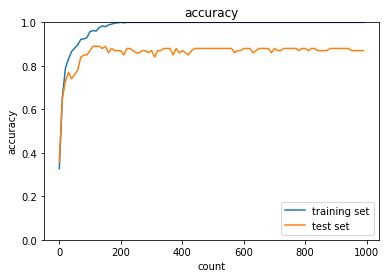

In [ ]:
from common import optimizer

# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(flatten=False)

print("データ読み込み完了")

# 処理に時間のかかる場合はデータを削減 
#x_train, d_train = x_train[:5000], d_train[:5000]
#x_test, d_test = x_test[:1000], d_test[:1000]
x_train, d_train = x_train[:500], d_train[:500]
x_test, d_test = x_test[:100], d_test[:100]


network = SimpleConvNet(input_dim=(1,28,28), conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

optimizer = optimizer.Adam()

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10



for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]
    
    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()